# Genre Data from Kaggle Dataset

This jupyter notebook explores the genre data from the Kaggle dataset, which was derived from Spotify.

### Load & Clean Up Data

In [1]:
import numpy as np
import csv
import re
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import pandas as pd
import seaborn as sns

In [2]:
def unpack_kaggle_csv(filename):
    with open(filename) as f:
        # Get reader object
        reader = csv.reader(f, delimiter=",")
        
        # Get title row
        headings = next(reader)
        headings_dict = {i:t for i,t in enumerate(headings)}
        
        unpacked_dict = {}
        
        for row in reader:
            title = row[0]
            unpacked_dict[title] = {}
            for i,item in enumerate(row):
                unpacked_dict[title][headings_dict[i]] = item

        return unpacked_dict

In [3]:
w_genres_data = unpack_kaggle_csv('data_w_genres_o.csv')

### Create Useful Data Structures

In [4]:
"""
    Important variables:
    - ALL_GENRES: a set of all unique genres in the spotify ds
    - ALL_GENRE_GROUPINGS: a list of genre groupings (which is a list of strings), 
                           to record what genres often appear with other genres
    - GENRE_COUNTER: a Counter object of how many times each genre appears in the genre groupings
"""

ALL_GENRES = set([])
all_genres_w_repeats = []
ALL_GENRE_GROUPINGS = []

for glist in w_genres_data.keys():
    genre_list = re.split(', ', re.sub('(\[|\]|\')', '', glist))
    if len(genre_list) > 0 and genre_list[0] != '':
        ALL_GENRE_GROUPINGS.append(genre_list)
        all_genres_w_repeats.extend(genre_list)

for grouping in ALL_GENRE_GROUPINGS:
    for genre in grouping:
        if genre != '': ALL_GENRES.add(genre)

GENRE_COUNTER = collections.Counter(all_genres_w_repeats)

Below are the 10 most common genres that appear with other genres.

In [5]:
print(GENRE_COUNTER.most_common(10))

[('rock', 502), ('dance pop', 405), ('pop', 387), ('hip hop', 381), ('rap', 372), ('pop rap', 335), ('modern rock', 327), ('folk rock', 326), ('country rock', 311), ('mellow gold', 297)]


In [6]:
genre_to_index = {g:i for i,g in enumerate(ALL_GENRES)}
index_to_genre = {i:g for i,g in enumerate(ALL_GENRES)}
n_genres = len(ALL_GENRES)
n_groupings = len(ALL_GENRE_GROUPINGS)

print("n_genres", n_genres)
print("n_groupings", n_groupings)

n_genres 2972
n_groupings 10742


### Term-Frequency Matrix (for Genres / genre groupings)

In [7]:
genre_tf_matrix = np.zeros((n_groupings,n_genres))

for i,grouping in enumerate(ALL_GENRE_GROUPINGS):
    for genre in grouping:
        genre_tf_matrix[i][genre_to_index[genre]] = 1

# Sum by genre (total appearances in a grouping, by genre)
print("Sum by genre")
tf_genre_sum = genre_tf_matrix.sum(axis=0)
print(len(tf_genre_sum), tf_genre_sum)
print()

# Sum by genre grouping (total genres per grouping)
print("Sum by genre grouping")
print(len(genre_tf_matrix.sum(axis=1)), genre_tf_matrix.sum(axis=1))
print()

# Top 10 most frequent genres
print("Top 10 most frequent genres")
sorted_idx = np.argsort(tf_genre_sum)[::-1][:10] # Indices of most frequent genres
top_10 = [(index_to_genre[idx],int(tf_genre_sum[idx])) for idx in sorted_idx]
print(top_10)

Sum by genre
2972 [ 5.  2.  1. ... 11.  1. 70.]

Sum by genre grouping
10742 [1. 3. 5. ... 2. 4. 2.]

Top 10 most frequent genres
[('rock', 502), ('dance pop', 405), ('pop', 387), ('hip hop', 381), ('rap', 372), ('pop rap', 335), ('modern rock', 327), ('folk rock', 326), ('country rock', 311), ('pop rock', 297)]


In [8]:
genre_tf_matrix.shape

(10742, 2972)

### Co-Occurrence Matrix of Genres

In [9]:
# Co-occurrence matrix
def get_co_mtx(input_tf_mtx, top_n=None):
    if top_n == None:
        top_n = input_tf_mtx.shape[1]
    input_sorted_indices = np.argsort(input_tf_mtx.sum(axis=0))[::-1][:top_n] # Indices of most frequent genres
    
    return np.dot(input_tf_mtx.T, input_tf_mtx)[np.ix_(input_sorted_indices,input_sorted_indices)]


In [10]:
def plot_co_mtx(input_tf_mtx, top_n=None):
    if top_n == None:
        top_n = input_tf_mtx.shape[1]
    
    top_n_genres = [index_to_genre[idx] for idx in np.argsort(genre_tf_matrix.sum(axis=0)[::-1][:top_n])]

    plt.figure(figsize=(20,15))
    top_n_ax = plt.axes()
    plt.title('Top ' + str(top_n) + ' Genre Co-Occurrences')
    sns.heatmap(pd.DataFrame(get_co_mtx(genre_tf_matrix, top_n=top_n)), xticklabels=top_n_genres, yticklabels=top_n_genres, ax=top_n_ax)

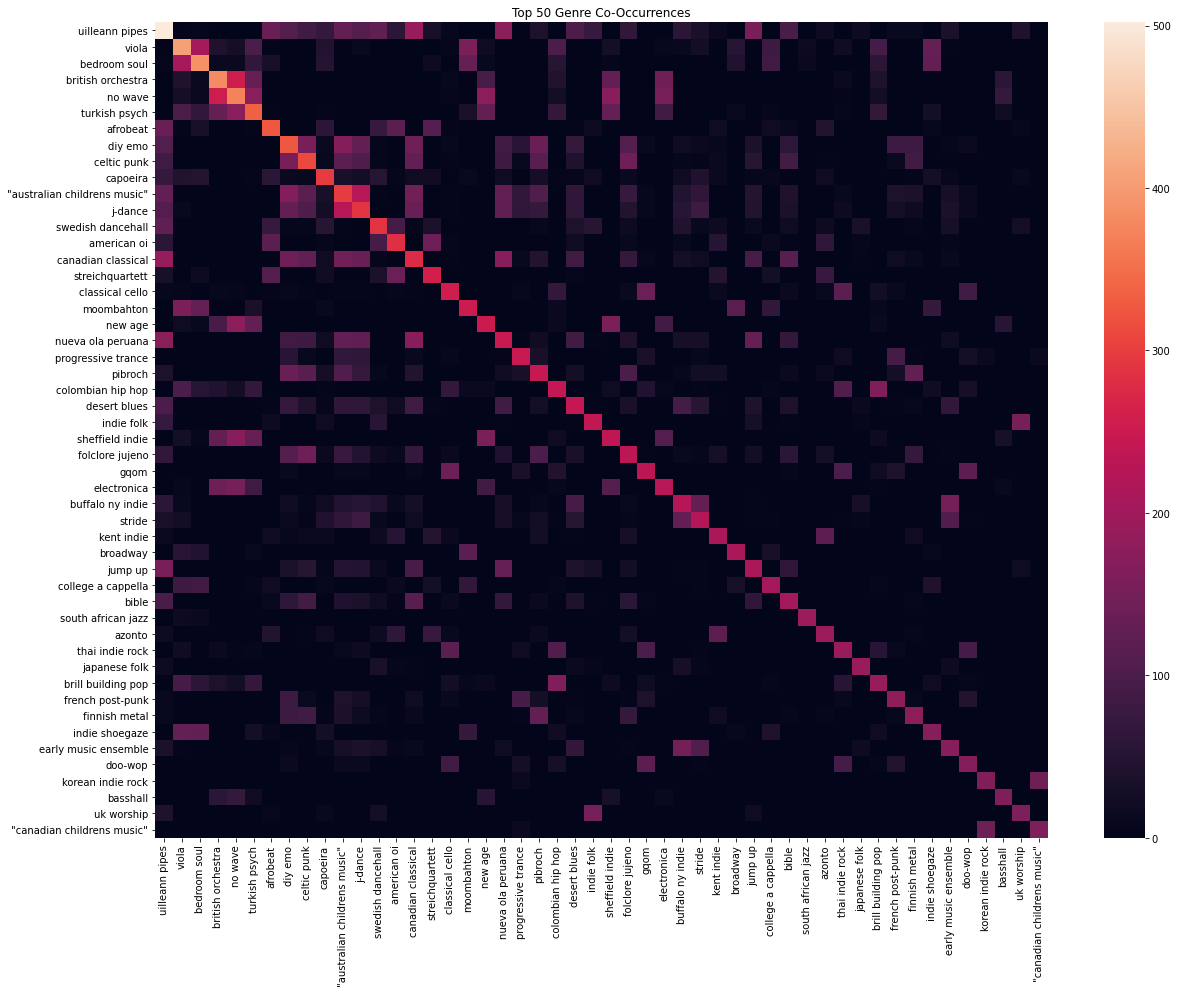

In [11]:
plot_co_mtx(genre_tf_matrix, top_n=50)

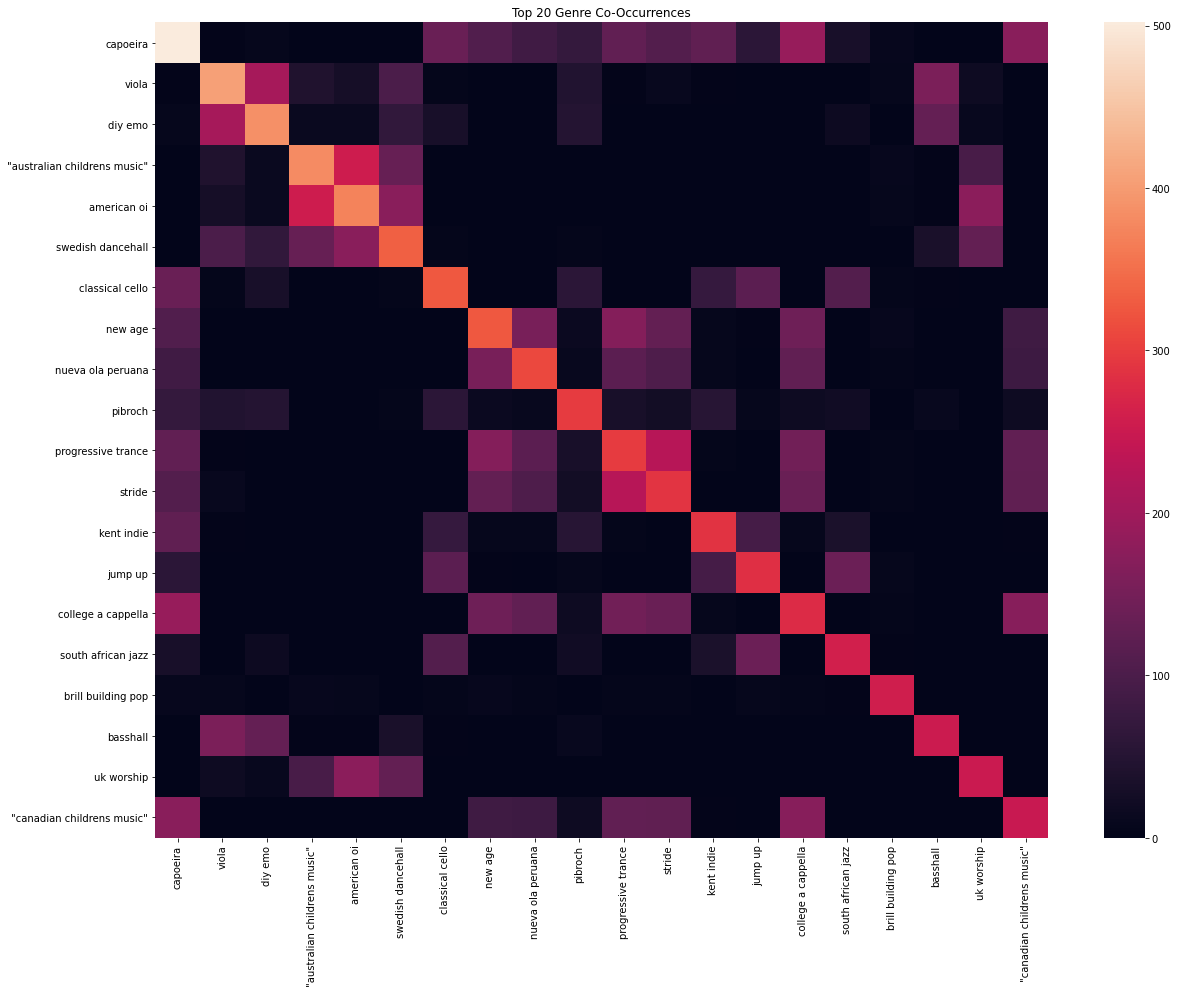

In [13]:
plot_co_mtx(genre_tf_matrix, top_n=20)

### Analysis

From the above heatmaps, we can see that there are not many significant areas of correlation between genres, although there are certainly patches in which genres correlate heavily with each other.